# 매개변수 갱신
- 확률적 경사하강법(Stochastic Gradient Descent)의 단점과 새로운 매개변수 최적화 기법

### SGD 구현하기
- 하나의 계층으로 구현하기 위해 Python Class로 구현하기
- 가중치 매개변수를 갱신하는 식 : w = w - dL/dW*lr
- 가중치를 갱신하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다
- 가중치를 갱신하는 방법을 SGD -> Momentum으로 변경한다면 갱신 클래스만 변경하기 된다

In [1]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr = lr # 초기화 때 입력받는 인수 '학습률'
        
    def update(self,params,grads): # 가중치 매개변수를 갱신하는 식
        for key in parmas.keys():
            params[key] -= grads[key] * lr

SGD의 단점을 확인하기 위해 비등방성 함수에서 최적화 과정을 시각화하자
- 지그재그로 최적화가 갱신되는 경로를 확인하고 하였으나 어떠한 이유에선지 지그재그로 갱신되는 모습이 보이지 않음
- 하지만 시각화 과정을 통해 최적화 갱신 경로가 상당히 비효율적인 것은 확인할 수 있음

In [50]:
def function_2(x):
    return (0.05)*x[0]**2 + x[1]**2

def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=["multi_index"],op_flags=["readwrite"])
    
    while not it.finished:
        idx = it.multi_index
        obj_val = x[idx]
        x[idx] = float(obj_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = float(obj_val) - h
        fxh2 = f(x) # f(x-h)
        
        x[idx] = float(obj_val) # 값 초기화
        grad[idx] = (fxh1 - fxh2) / (2*h)
        it.iternext() # False 반복문 종료
    return grad

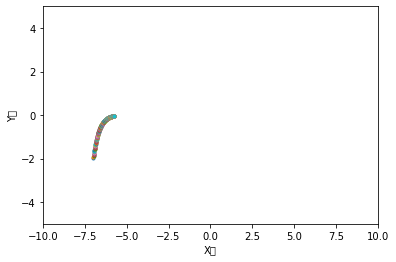

In [60]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-5,5)
x = np.array([-7.0,-2.0])
lr = 0.01
for i in range(200):
    x -= numerical_gradient(function_2,x) * lr
    plt.plot(x[0],x[1],'.')

### 모멘텀을 통한 SGD의 단점 해결
- 새로운 v 변수의 등장, 속도에 해당함
- momentum * v 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할
- SGD의 단점인 지그재그 움직임을 줄여준다

In [61]:
class Momentum:
    def __init__(self,lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self,params,grads):
        if self.v is None: # v가 None이라면 v 생성하기, 매개변수와 같은 구조의 데이터를 저장
            self.v = {} 
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.mometum * self.v[key] - self.lr*grads[key]
                params[key] += self.v[key]        

- 학습률을 0.01로 설정하고, 매개변수 갱신을 200회 한 결과
- SGD는 아직 최솟값인 (0,0)에 도달하지 못했지만, 모멘텀은 이미 도달하였다
- 모멘텀 방법의 효율성 확인 가능

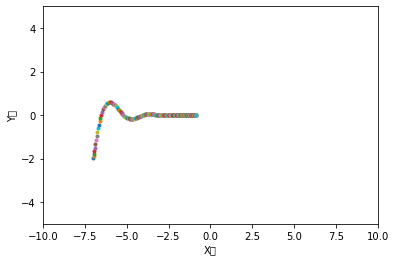

In [62]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-5,5)
x = np.array([-7.0,-2.0])
lr = 0.01
momentum = 0.9
v = 0
for i in range(200):
    v = momentum * v - numerical_gradient(function_2,x) * lr
    x += v
    plt.plot(x[0],x[1],'.')

### AdaGrad
- 학습률(learning rate)이 너무 작으면 학습 시간이 길어지고, 너무 크면 발산해 학습이 제대로 X
- 학습률 감소(learning rate decay) : 위 문제를 해결하는 학습을 진행하면서 점차 학습률을 줄여감
- 일괄적으로 전체 학습률을 낮추는 대신 각각 매개변수에 맞게 조정하는 방법, AdaGrad
- 처음에는 큰 폭으로 움직이지며 크게 갱신되지만 점차 갱신 강도가 빠르게 약해지고 지그재그 움직임 감소

In [56]:
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr = lr
        self.h = None
    def update(self,params,grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0으로 나눠는 division zero 해결

- 학습률을 0.01로 설정하고, 매개변수 갱신을 5000회 한 결과
- AdaGrad는 최솟값에 도달하지 못했음
- AdaGrad의 갱신 과정을 성공적으로 시각화하지 못한 것 같음

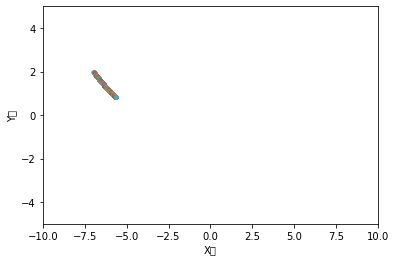

In [67]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-5,5)
x = np.array([-7.0,2.0])
lr = 0.01
h = 0
for i in range(5000):
    h += numerical_gradient(function_2,x) ** 2
    x -= lr * numerical_gradient(function_2,x) / (np.sqrt(h) + 1e-7)
    plt.plot(x[0],x[1],'.')